<a href="https://colab.research.google.com/github/UBGidado/My_Research/blob/main/Clustering_Verbs%2C_Subjects_%26_Objects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Dependences and imports

In [1]:
!pip install -q kaggle datasets spacy transformers
!python -m spacy download en_core_web_lg
!pip install flair
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [2]:
import os
import re
import torch
import numpy as np
import pandas as pd
import kagglehub
import spacy
from tqdm.auto import tqdm
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from flair.models import SequenceTagger
from flair.data import Sentence
from sklearn.decomposition import PCA
from google.colab import drive
from collections import Counter
from spacy.matcher import Matcher
from datasets import load_dataset
from google.colab import files

## Setting up Kaggle API

In [3]:
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle (1).json to kaggle (1).json
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


## Loading Dataset 1 (Hugging face)

In [4]:
!wget https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/resolve/main/raw/Cognitive_distortions.csv

# Load and structure the data
df1 = pd.read_csv("Cognitive_distortions.csv")
df1 = df1.rename(columns={
    'Text': 'Patient Question',
    'Label': 'Dominant Distortion'
})
df1.insert(1, "Distorted part", value=np.nan)
df1.insert(3, "Secondary Distortion (Optional)", value=np.nan)

df1.head()

--2025-06-21 02:33:55--  https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/resolve/main/raw/Cognitive_distortions.csv
Resolving huggingface.co (huggingface.co)... 3.163.189.74, 3.163.189.114, 3.163.189.90, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1021440 (998K) [text/plain]
Saving to: ‘Cognitive_distortions.csv’

Cognitive_distortio 100%[===================>] 997.50K  5.06MB/s    in 0.2s    

2025-06-21 02:33:56 (5.06 MB/s) - ‘Cognitive_distortions.csv’ saved [1021440/1021440]



,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN


In [5]:
for col in ["Distorted part", "Dominant Distortion", "Secondary Distortion (Optional)"]:
  print(f"Unique values in '{col}':")
  if col in df1.columns:
    print(df1[col].unique())
  else:
    print(f"Column '{col}' not found in df1.")
  print("-" * 30)

Unique values in 'Distorted part':
[nan]
------------------------------
Unique values in 'Dominant Distortion':
['Distortion' 'No Distortion']
------------------------------
Unique values in 'Secondary Distortion (Optional)':
[nan]
------------------------------


## Load Dataset 2 (Kaggle)

In [6]:
multiclass_dataset_path = kagglehub.dataset_download(
    "sagarikashreevastava/cognitive-distortion-detetction-dataset"
)
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

Path to dataset files: /kaggle/input/cognitive-distortion-detetction-dataset


### Cleaning & Structuring df2

In [7]:
df2 = pd.read_csv(multiclass_dataset_file_path)
df2 = df2.drop('Id_Number', axis=1) # deleting column with id
df2

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [8]:
for col in ["Distorted part", "Dominant Distortion", "Secondary Distortion (Optional)"]:
  print(f"Unique values in '{col}':")
  if col in df2.columns:
    print(df2[col].unique())
  else:
    print(f"Column '{col}' not found in df1.")
  print("-" * 30)

Unique values in 'Distorted part':
['The voice are always fimilar (someone she knows) Im very concerned about this and hope it has nothing to do with my pregnancy while on active duty.'
 'I feel trapped inside my disgusting self and like I’m willing to do anything to escape it.I’m just afraid sometimes that since I’m not really thinking during these times that I might do something to myself–especially since I think during these times that I don’t deserve to get help or that I’m not worth disturbing people by calling them.'
 nan ...
 'However, I am not happy, at the least only half of me is happy at a time. I feel as though I am having two different feelings. One is of an extrovert, and the other is of an introvert. I do not want to be alone but even so I want to be isolated.'
 'Now I am at university my peers around me all have social lives and boyfriends and so it hurts more now. I tried making friends but seem to have a perpetual block for the last 10 years.'
 'He claims he’s severel

## Concatenate into df3

In [9]:
df3 = pd.concat([df1, df2], ignore_index=True)
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [10]:
df3 = pd.concat([df1[["Patient Question"]], df2], ignore_index=True)
df3 = df3.rename(columns={"Patient Question": "text"})
df3 = df3.reset_index().rename(columns={"index": "id"})

print(" Dataset 1 and Dataset 2 loaded and combined into df3.")
print(df3.head())

 Dataset 1 and Dataset 2 loaded and combined into df3.
   id                                               text Distorted part  \
0   0      I'm such a failure I never do anything right.            NaN   
1   1       Nobody likes me because I'm not interesting.            NaN   
2   2   I can't try new things because I'll just mess...            NaN   
3   3   My boss didn't say 'good morning' she must be...            NaN   
4   4   My friend didn't invite me to the party I mus...            NaN   

  Dominant Distortion Secondary Distortion (Optional)  
0                 NaN                             NaN  
1                 NaN                             NaN  
2                 NaN                             NaN  
3                 NaN                             NaN  
4                 NaN                             NaN  


In [11]:
gpu_available = torch.cuda.is_available()

if gpu_available:
    print(" GPU is available")
else:
  print("CPU")

CPU


### Extracting triples from text column

In [12]:
# Load models
nlp = spacy.load("en_core_web_lg")
flair_tagger = SequenceTagger.load("flair/ner-english")

# Define social/psychological relationship verbs
SOCIAL_RELATION_VERBS = {
    "like", "love", "hate", "trust", "distrust", "fear", "admire", "resent",
    "blame", "support", "oppose", "befriend", "avoid", "confide", "believe",
    "doubt", "respect", "despise", "envy", "forgive", "help", "betray", "accept",
    "teach", "raise", "parent", "marry", "date", "partner with", "understand"
    "open up to", "connect with", "relate to", "abuse", "neglect", "criticize",
    "accuse", "reject", "abandon", "protect", "depend on", "rely on", "dislike",
    "fear", "despise", "admire", "miss", "care for", "cherish", "envy"
}

def extract_entity_or_chunk(token, doc):
    """Enhanced with Flair NER for better entity recognition"""
    # First check spaCy entities
    for ent in doc.ents:
        if token.i in range(ent.start, ent.end):
            return ent.text

    # Then check noun chunks
    for chunk in doc.noun_chunks:
        if token.i in range(chunk.start, chunk.end):
            return chunk.text

    # If nothing found, use Flair NER
    flair_sentence = Sentence(token.text, use_tokenizer=True)
    flair_tagger.predict(flair_sentence)
    for entity in flair_sentence.get_spans('ner'):
        if entity.tag in ['PER', 'ORG']:
            return entity.text

    return token.text

def extract_verb_based_relationships(sent, doc):
    """Extract relationships expressed through verbs"""
    relationships = []

    for token in sent:
        # Check if verb is a social relationship marker
        if token.pos_ == "VERB" and token.lemma_ in SOCIAL_RELATION_VERBS:
            subj = obj = None

            # Find subject and object
            for child in token.children:
                if "subj" in child.dep_ or child.dep_ == "agent":
                    subj = extract_entity_or_chunk(child, doc)
                if "obj" in child.dep_ or child.dep_ == "pobj":
                    obj = extract_entity_or_chunk(child, doc)

            if subj and obj:
                relationships.append({
                    'type': 'social',
                    'subject': subj,
                    'relation': token.lemma_,
                    'object': obj,
                    'context': sent.text
                })

    return relationships

def extract_structural_relationships(sent, doc):
    """Extract familial and other structural relationships"""
    relationships = []
    text = sent.text.lower()

def extract_relationships(text):
    """
    Extract both social/psychological and structural relationships.
    Returns: List of dictionaries with relationship info
    """
    doc = nlp(text)
    relationships = []

    for sent in doc.sents:
        # Extract verb-based relationships
        relationships.extend(extract_verb_based_relationships(sent, doc))

    return relationships

# Example usage:
sample_text = """
John trusts Mary but fears hospitals. He is the son of Robert.
Sarah is friends with Emily and works as an employee of Google.
"""
print(extract_relationships(sample_text))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/419M [00:00<?, ?B/s]

2025-06-21 02:34:09,365 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>
[{'type': 'social', 'subject': 'John', 'relation': 'trust', 'object': 'fears hospitals', 'context': 'John trusts Mary but fears hospitals.'}]


## Batch Extract Relationship Triples Using spaCy NLP Pipeline

In [13]:
def extract_relationships_from_sentence(sent, social_verbs):
    """Extract both verb-based and structural relationships from a single sentence"""
    relationships = []

    # Process verb-based relationships
    for token in sent:
        if token.pos_ == "VERB" and token.lemma_.lower() in social_verbs:
            subject = object_ = None

            for child in token.children:
                if "subj" in child.dep_ or child.dep_ == "agent":
                    subject = extract_entity_or_chunk(child, sent.doc)
                elif "obj" in child.dep_ or child.dep_ == "pobj":
                    object_ = extract_entity_or_chunk(child, sent.doc)

            if subject and object_:
                relationships.append({
                    "subject": subject,
                    "relation": token.lemma_,
                    "object": object_,
                    "context": sent.text,
                    "sentence_start": sent.start_char,
                    "sentence_end": sent.end_char
                })

    return relationships

def find_entities_around_pattern(sent, pattern_match):
    """Find potential subject before pattern and object after pattern"""
    # Convert character positions to token positions
    start_pos = pattern_match.start()
    end_pos = pattern_match.end()

    # Find tokens that contain the matched pattern
    pattern_tokens = [t for t in sent
                     if t.idx >= sent.start_char + start_pos
                     and t.idx + len(t.text) <= sent.start_char + end_pos]

    if not pattern_tokens:
        return None, None

    # Get subject (last noun before pattern)
    subject = None
    for token in sent:
        if token.i < pattern_tokens[0].i and token.pos_ in ["NOUN", "PROPN"]:
            subject = extract_entity_or_chunk(token, sent.doc)

    # Get object (first noun after pattern)
    object_ = None
    for token in sent:
        if token.i > pattern_tokens[-1].i and token.pos_ in ["NOUN", "PROPN"]:
            object_ = extract_entity_or_chunk(token, sent.doc)
            break

    return subject, object_

def extract_all_relationships(text_series, nlp_model, social_verbs):
    """Process all texts to extract relationships"""
    return [
        [rel for sent in doc.sents
         for rel in extract_relationships_from_sentence(sent, social_verbs)]
        for doc in tqdm(
            nlp_model.pipe(text_series, batch_size=64, n_process=1),
            total=len(text_series),
            desc="Extracting relationships"
        )
    ]

# Apply to DataFrame
df3["relationships"] = extract_all_relationships(
    df3["text"],
    nlp,
    SOCIAL_RELATION_VERBS
)

Extracting relationships: 100%|██████████| 6057/6057 [02:13<00:00, 45.37it/s]


In [14]:
# Step 1: Initialize a list to hold detailed relationship rows
detailed_records = []

# Step 2: Iterate over df3 to extract and flatten multiple relationships
for _, row in df3.iterrows():
    text_id = row["id"]
    text = row["text"]
    dominant_distortion = row["Dominant Distortion"]
    secondary_distortion = row["Secondary Distortion (Optional)"]

    # Make sure we have a list of relationships
    relationships = row["relationships"]
    if isinstance(relationships, list):
        for rel in relationships:
            subj = rel.get("subject")
            rel_verb = rel.get("relation")
            obj = rel.get("object")
            context = rel.get("context")

            if subj and rel_verb and obj:
                detailed_records.append({
                    "text_id": text_id,
                    "context": context,
                    "subject": subj,
                    "relation": rel_verb,
                    "object": obj,
                    "dominant_distortion": dominant_distortion,
                    "secondary_distortion": secondary_distortion
                })

# Step 3: Create DataFrame from all extracted triples
triples_df = pd.DataFrame(detailed_records)

# Step 4: Reset index and assign an ID column
if not triples_df.empty:
    triples_df.reset_index(inplace=True)
    triples_df.rename(columns={"index": "id"}, inplace=True)

# Step 5: Preview
print("Extracted all relationships into triples_df")
display(triples_df.head())

Extracted all relationships into triples_df


,id,text_id,context,subject,relation,object,dominant_distortion,secondary_distortion
0,0,1,Nobody likes me because I'm not interesting.,Nobody,like,me,NaN,NaN
1,1,10,My partner didn't say 'I love you' today our ...,I,love,you,NaN,NaN
2,2,12,I didn't get a reply to my email they must ha...,they,hate,me,NaN,NaN
3,3,23,No one will ever love me because I'm too shy.,No one,love,me,NaN,NaN
4,4,39,My boss criticized my report she thinks I'm n...,My boss,criticize,my report,NaN,NaN


In [15]:
print(len(triples_df))

2046


## Combined Solution (Summary + Detailed Triples)

In [16]:
# 1. Create Summary DataFrame (id, text, list-of-relationships)
summary_df = df3[["id", "text"]].copy()
summary_df["list-of-relationships"] = df3["relationships"]

# 2. Create Detailed Relationships DataFrame
detailed_records = []
for _, row in df3.iterrows():
    for relationship in row["relationships"]:
        subj = relationship.get('subject')
        rel = relationship.get('relation')
        obj = relationship.get('object')

        if subj and rel and obj:
             detailed_records.append({
                "text_id": row["id"],
                "context": row["text"],  # Using full text as context
                "relationship": (rel, subj, obj)
            })

triples_df = pd.DataFrame(detailed_records)
if not triples_df.empty:
    triples_df.reset_index(inplace=True)
    triples_df.rename(columns={"index": "id"}, inplace=True)

print("Summary DataFrame:")
display(summary_df.head())

print("\nTriples DataFrame:")
display(triples_df.head())

Summary DataFrame:


,id,text,list-of-relationships
0,0,I'm such a failure I never do anything right.,[]
1,1,Nobody likes me because I'm not interesting.,"[{'subject': ' Nobody', 'relation': 'like', 'o..."
2,2,I can't try new things because I'll just mess...,[]
3,3,My boss didn't say 'good morning' she must be...,[]
4,4,My friend didn't invite me to the party I mus...,[]



Triples DataFrame:


,id,text_id,context,relationship
0,0,1,Nobody likes me because I'm not interesting.,"(like, Nobody, me)"
1,1,10,My partner didn't say 'I love you' today our ...,"(love, I, you)"
2,2,12,I didn't get a reply to my email they must ha...,"(hate, they, me)"
3,3,23,No one will ever love me because I'm too shy.,"(love, No one, me)"
4,4,39,My boss criticized my report she thinks I'm n...,"(criticize, My boss, my report)"


## Inspecting 100 samples for manual evaluation

In [17]:
# 1. Randomly sample 100 triples from the detailed relationship table
sample_size = 100
sample_df = triples_df.sample(n=sample_size, random_state=42).copy()

# 2. Add manual annotation columns
sample_df["is_correct"] = ""
sample_df["comments"] = ""

# 3. Export the sample to CSV for manual review
sample_df.to_csv("manual_evaluation_sample.csv", index=False)

print(" Sample exported for annotation: 'manual_evaluation_sample.csv'")


 Sample exported for annotation: 'manual_evaluation_sample.csv'


## Computing Precision and Recall

In [19]:
# 1. Load and prepare data
annotated_df = pd.read_csv("/content/manual_evaluation_sample_100.csv")
annotated_df.columns = annotated_df.columns.str.strip()  # Clean column names

# 2. Validate binary columns
required_columns = {'is_correct', 'is_missing'}
assert required_columns.issubset(annotated_df.columns), \
       f"Missing required columns: {required_columns - set(annotated_df.columns)}"

# 3. Calculate metrics
metrics = {
    'precision': annotated_df['is_correct'].mean(),
    'recall': annotated_df['is_correct'].sum() /
              (annotated_df['is_correct'].sum() + annotated_df['is_missing'].sum()),
    'extracted_count': len(annotated_df),
    'correct_count': annotated_df['is_correct'].sum(),
    'missing_count': annotated_df['is_missing'].sum()
}

# 4. Display comprehensive results
print(" Evaluation Metrics")
print(f"• Precision: {metrics['precision']:.1%} ({metrics['correct_count']}/{metrics['extracted_count']})")
print(f"• Recall:    {metrics['recall']:.1%} ({metrics['correct_count']}/{metrics['correct_count'] + metrics['missing_count']})")
print(f"• Missing Relations: {metrics['missing_count']}")
print(f"\n Coverage: {1 - metrics['missing_count']/metrics['extracted_count']:.1%} of expected relations found")

 Evaluation Metrics
• Precision: 70.0% (70/100)
• Recall:    97.2% (70/72)
• Missing Relations: 2

 Coverage: 98.0% of expected relations found


## Clustering Relationships by Verb Type (Using Embeddings + Clustering)

In [20]:
# Extract only unique verbs (relations) from the triples
triples_df["verb"] = triples_df["relationship"].apply(lambda x: x[0] if isinstance(x, tuple) else None)
unique_verbs = sorted(triples_df["verb"].dropna().unique())
print(f"Found {len(unique_verbs)} unique verbs:", unique_verbs)


Found 34 unique verbs: ['abandon', 'abuse', 'accept', 'accuse', 'admire', 'avoid', 'befriend', 'believe', 'betray', 'blame', 'criticize', 'date', 'despise', 'dislike', 'doubt', 'envy', 'fear', 'forgive', 'hate', 'help', 'like', 'love', 'marry', 'miss', 'neglect', 'parent', 'protect', 'raise', 'reject', 'resent', 'respect', 'support', 'teach', 'trust']


#### Convert Verbs to Vectors Using Pretrained Model


In [21]:
nlp_lg = spacy.load("en_core_web_lg")
verb_vectors = np.array([nlp_lg(verb).vector for verb in unique_verbs])

#### Apply Clustering (KMeans)


In [22]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(verb_vectors)

# Map verbs to cluster IDs
verb_cluster_map = {verb: int(cluster) for verb, cluster in zip(unique_verbs, clusters)}

#### Visualizing Clusters

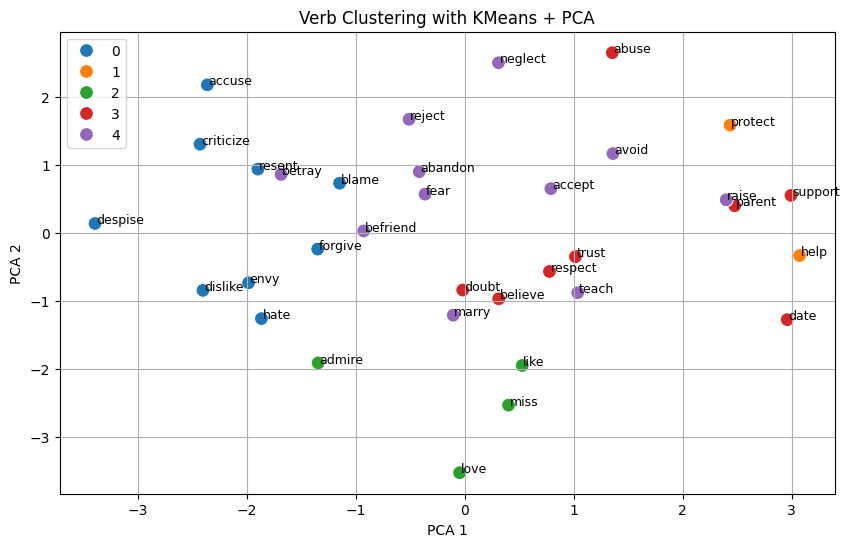

In [23]:
# Reduce dimensions for plotting
pca = PCA(n_components=2)
verb_vec_2d = pca.fit_transform(verb_vectors)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=verb_vec_2d[:, 0], y=verb_vec_2d[:, 1], hue=clusters, palette="tab10", s=100)

# Annotate points
for i, verb in enumerate(unique_verbs):
    plt.text(verb_vec_2d[i, 0] + 0.01, verb_vec_2d[i, 1], verb, fontsize=9)

plt.title("Verb Clustering with KMeans + PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

#### mapping each verb to it cluster and return a list of verbs to each cluster

In [24]:
cluster_to_verbs = {}
for verb, cluster_id in verb_cluster_map.items():
    if cluster_id not in cluster_to_verbs:
        cluster_to_verbs[cluster_id] = []
    cluster_to_verbs[cluster_id].append(verb)

# Print the list of verbs for each cluster
print("\nVerbs assigned to each cluster:")
for cluster_id, verbs_list in cluster_to_verbs.items():
    print(f"Cluster {cluster_id}: {verbs_list}")


Verbs assigned to each cluster:
Cluster 4: ['abandon', 'accept', 'avoid', 'befriend', 'betray', 'fear', 'marry', 'neglect', 'raise', 'reject', 'teach']
Cluster 3: ['abuse', 'believe', 'date', 'doubt', 'parent', 'respect', 'support', 'trust']
Cluster 0: ['accuse', 'blame', 'criticize', 'despise', 'dislike', 'envy', 'forgive', 'hate', 'resent']
Cluster 2: ['admire', 'like', 'love', 'miss']
Cluster 1: ['help', 'protect']


#### mapping clusters to semantic categories

In [27]:
# Define manual labels based on cluster inspection
verb_cluster_labels = {
    0: "Negative Affect / Conflict Emotion",
    1: "Supportive Actions",
    2: "Positive Affect / Affection",
    3: "Interpersonal Beliefs / Roles",
    4: "Social Attachment & Rejection"
}

# Add cluster label to each row in triples_df
triples_df["verb_cluster"] = triples_df["verb"].map(verb_cluster_map)
triples_df["verb_cluster_label"] = triples_df["verb_cluster"].map(verb_cluster_labels)

 ## Clustering Subjects and Objects per Relation

In [28]:
# Extract & Normalize Subjects/Objects

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # Disable unused components

def normalize_phrase(phrase):
    if not isinstance(phrase, str):
        return ""
    doc = nlp(phrase.lower())
    return " ".join([token.lemma_ for token in doc if not token.is_punct]).strip()

# Apply normalization
triples_df["normalized_subject"] = triples_df["relationship"].apply(lambda x: normalize_phrase(x[1]) if isinstance(x, tuple) and len(x) > 1 else "")
triples_df["normalized_object"] = triples_df["relationship"].apply(lambda x: normalize_phrase(x[2]) if isinstance(x, tuple) and len(x) > 2 else "")

#### Vectorize Normalized Phrases

In [29]:
#Load the large English model for better word vectors
nlp = spacy.load("en_core_web_lg")

# Define standard vector length for this model
VECTOR_LENGTH = nlp.vocab.vectors_length  # Typically 300 for 'lg' model

def get_phrase_vector(phrase):
    """Convert a phrase to its vector representation by averaging word vectors.
    Returns a zero vector if no valid tokens are found.
    """
    # Skip empty strings
    if not isinstance(phrase, str) or not phrase.strip():
        return np.zeros(VECTOR_LENGTH)

    # Process text and get valid word vectors
    doc = nlp(phrase)
    vectors = [
        token.vector
        for token in doc
        if token.has_vector
        and token.vector.size == VECTOR_LENGTH
    ]

    # Return mean vector or zeros if no valid vectors
    return np.mean(vectors, axis=0) if vectors else np.zeros(VECTOR_LENGTH)

# Generate vectors for all subjects and objects
triples_df["subject_vec"] = triples_df["normalized_subject"].apply(get_phrase_vector)
triples_df["object_vec"] = triples_df["normalized_object"].apply(get_phrase_vector)


####  Cluster Subjects and Objects

In [30]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

# Prepare matrix of vectors
subject_matrix = np.vstack(triples_df["subject_vec"].values)
object_matrix = np.vstack(triples_df["object_vec"].values)

# Handle zero vectors by adding a small epsilon before normalization
epsilon = 1e-6
subject_matrix[~subject_matrix.any(axis=1)] += epsilon
object_matrix[~object_matrix.any(axis=1)] += epsilon


# Normalize vectors (cosine)
subject_matrix = normalize(subject_matrix)
object_matrix = normalize(object_matrix)

# Choose number of clusters
num_subject_clusters = 3
num_object_clusters = 3

# Cluster
subject_clustering = AgglomerativeClustering(n_clusters=num_subject_clusters, metric="cosine", linkage="average")
object_clustering = AgglomerativeClustering(n_clusters=num_object_clusters, metric="cosine", linkage="average")

triples_df["subject_cluster"] = subject_clustering.fit_predict(subject_matrix)
triples_df["object_cluster"] = object_clustering.fit_predict(object_matrix)

#### Visualize or Summarize Clusters

In [31]:
# Top 5 normalized subjects per subject cluster
print(" Subject clusters:")
for i in range(num_subject_clusters):
    members = triples_df[triples_df["subject_cluster"] == i]["normalized_subject"]
    print(f"Cluster {i}: {members.value_counts().head(5).to_dict()}")

# Top 5 normalized objects per object cluster
print("\n Object clusters:")
for i in range(num_object_clusters):
    members = triples_df[triples_df["object_cluster"] == i]["normalized_object"]
    print(f"Cluster {i}: {members.value_counts().head(5).to_dict()}")


 Subject clusters:
Cluster 0: {'I': 1054, 'he': 262, 'she': 160, 'they': 135, 'we': 37}
Cluster 1: {'-to': 2, '': 1, '.i': 1, 'run.i': 1}
Cluster 2: {'misbehave': 1}

 Object clusters:
Cluster 0: {'I': 503, 'he': 230, 'she': 144, 'it': 97, 'they': 78}
Cluster 1: {'dogs(since': 2, 'boyfre': 2, 'anyone-': 1, 'himand': 1, 'him,,,i': 1}
Cluster 2: {'an eeg': 1, 'autistic': 1, 'phobic': 1}


In [32]:
subject_cluster_labels = {
    0: "Self & Others (Human Agents)",
    1: "Parsing Errors / Noise",
    2: "Specific Actions"
}
# Add subject cluster label to each row in triples_df
triples_df["subject_cluster_label"] = triples_df["subject_cluster"].map(subject_cluster_labels)


object_cluster_labels = {
    0: "Human Targets",
    1: "Malformed Text / Noise",
    2: "Psychological/Condition Terms"
}
# Add object cluster label to each row in triples_df
triples_df["object_cluster_label"] = triples_df["object_cluster"].map(object_cluster_labels)

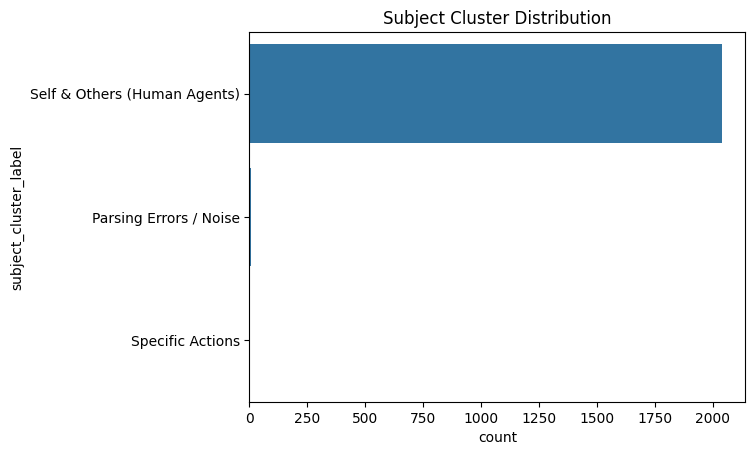

In [33]:
import seaborn as sns

# Plot subject cluster distribution
sns.countplot(
    data=triples_df,
    y="subject_cluster_label",
    order=subject_cluster_labels.values()
)
plt.title("Subject Cluster Distribution");

In [34]:
triples_df.head()

,id,text_id,context,relationship,verb,verb_cluster,verb_cluster_label,normalized_subject,normalized_object,subject_vec,object_vec,subject_cluster,object_cluster,subject_cluster_label,object_cluster_label
0,0,1,Nobody likes me because I'm not interesting.,"(like, Nobody, me)",like,2,Positive Affect / Affection,nobody,I,"[-0.18909, 0.06159, -0.2015, -0.33876, -0.1915...","[0.18733, 0.40595, -0.51174, -0.55482, 0.03971...",0,0,Self & Others (Human Agents),Human Targets
1,1,10,My partner didn't say 'I love you' today our ...,"(love, I, you)",love,2,Positive Affect / Affection,I,you,"[0.18733, 0.40595, -0.51174, -0.55482, 0.03971...","[-0.11076, 0.30786, -0.5198, 0.035138, 0.10368...",0,0,Self & Others (Human Agents),Human Targets
2,2,12,I didn't get a reply to my email they must ha...,"(hate, they, me)",hate,0,Negative Affect / Conflict Emotion,they,I,"[-0.13889, 0.10991, -0.20471, -0.32585, 0.0072...","[0.18733, 0.40595, -0.51174, -0.55482, 0.03971...",0,0,Self & Others (Human Agents),Human Targets
3,3,23,No one will ever love me because I'm too shy.,"(love, No one, me)",love,2,Positive Affect / Affection,no one,I,"[-0.0435695, 0.0728705, -0.294285, -0.0587795,...","[0.18733, 0.40595, -0.51174, -0.55482, 0.03971...",0,0,Self & Others (Human Agents),Human Targets
4,4,39,My boss criticized my report she thinks I'm n...,"(criticize, My boss, my report)",criticize,0,Negative Affect / Conflict Emotion,my boss,my report,"[-0.163765, 0.15114, -0.33055001, 0.1874195, 0...","[-0.38776, 0.21077001, -0.30114502, 0.32098502...",0,0,Self & Others (Human Agents),Human Targets


In [35]:
# prompt: add 'Dominant Distortion_',
#        'Secondary Distortion (Optional)' from df3 to triples_df

triples_df['Dominant Distortion'] = triples_df['text_id'].map(df3.set_index('id')['Dominant Distortion'])
triples_df['Secondary Distortion (Optional)'] = triples_df['text_id'].map(df3.set_index('id')['Secondary Distortion (Optional)'])

# Display the updated triples_df
print("Triples DataFrame with Distortion columns:")
display(triples_df.head())
print(len(triples_df))

Triples DataFrame with Distortion columns:


,id,text_id,context,relationship,verb,verb_cluster,verb_cluster_label,normalized_subject,normalized_object,subject_vec,object_vec,subject_cluster,object_cluster,subject_cluster_label,object_cluster_label,Dominant Distortion,Secondary Distortion (Optional)
0,0,1,Nobody likes me because I'm not interesting.,"(like, Nobody, me)",like,2,Positive Affect / Affection,nobody,I,"[-0.18909, 0.06159, -0.2015, -0.33876, -0.1915...","[0.18733, 0.40595, -0.51174, -0.55482, 0.03971...",0,0,Self & Others (Human Agents),Human Targets,NaN,NaN
1,1,10,My partner didn't say 'I love you' today our ...,"(love, I, you)",love,2,Positive Affect / Affection,I,you,"[0.18733, 0.40595, -0.51174, -0.55482, 0.03971...","[-0.11076, 0.30786, -0.5198, 0.035138, 0.10368...",0,0,Self & Others (Human Agents),Human Targets,NaN,NaN
2,2,12,I didn't get a reply to my email they must ha...,"(hate, they, me)",hate,0,Negative Affect / Conflict Emotion,they,I,"[-0.13889, 0.10991, -0.20471, -0.32585, 0.0072...","[0.18733, 0.40595, -0.51174, -0.55482, 0.03971...",0,0,Self & Others (Human Agents),Human Targets,NaN,NaN
3,3,23,No one will ever love me because I'm too shy.,"(love, No one, me)",love,2,Positive Affect / Affection,no one,I,"[-0.0435695, 0.0728705, -0.294285, -0.0587795,...","[0.18733, 0.40595, -0.51174, -0.55482, 0.03971...",0,0,Self & Others (Human Agents),Human Targets,NaN,NaN
4,4,39,My boss criticized my report she thinks I'm n...,"(criticize, My boss, my report)",criticize,0,Negative Affect / Conflict Emotion,my boss,my report,"[-0.163765, 0.15114, -0.33055001, 0.1874195, 0...","[-0.38776, 0.21077001, -0.30114502, 0.32098502...",0,0,Self & Others (Human Agents),Human Targets,NaN,NaN


2046


In [37]:
triples_df.columns

Index(['id', 'text_id', 'context', 'relationship', 'verb', 'verb_cluster',
       'verb_cluster_label', 'normalized_subject', 'normalized_object',
       'subject_vec', 'object_vec', 'subject_cluster', 'object_cluster',
       'subject_cluster_label', 'object_cluster_label', 'Dominant Distortion',
       'Secondary Distortion (Optional)'],
      dtype='object')

In [38]:
# prompt: save triples_df in my drive in My Research folder
drive.mount('/content/drive')
triples_df.to_csv('/content/drive/My Drive/My Research/triples_df.csv', index=False)
print("triples_df saved to Google Drive.")

Mounted at /content/drive
triples_df saved to Google Drive.
